# Try using HDBSCAN to cluster things

Links:
* [HDBSCAN vs other clustering algorithms - an exploration](https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html)
* [sklearn HDBSCAN docs](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html)

## Notes to self

do I need to normalize the data?
try different distance metrics?

# TODO

* maybe set colors of unclust to white
* metrics: what fraction of hashes clustered; coherence (??) of clusters;
* downstream: which clusters in which samples?

In [1]:
ls agatha-genomes.10k.presence.csv

agatha-genomes.10k.presence.csv


In [2]:
from sourmash import sourmash_args
import numpy
import seaborn as sns
import sklearn.cluster
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.lines import Line2D

## First, try looking at the sample presence matrix

In [3]:
csvfile = 'agatha-genomes.10k.presence.csv'

In [4]:
with sourmash_args.FileInputCSV(csvfile) as r:
    rows = list(r)

# pick out all the distinct queries/matches.                            
print(f"loaded {len(rows)} rows from '{csvfile}'")
queries = set([row["query_name"] for row in rows])
against = set([row["match_name"] for row in rows])
print(f"loaded {len(queries)} x {len(against)} total elements")

queries = list(sorted(queries))
against = list(sorted(against))

query_d = {}
for n, query_name in enumerate(queries):
    query_d[query_name] = n

against_d = {}
for n, against_name in enumerate(against):
    against_d[against_name] = n

query_d_items = list(sorted(query_d.items(), key=lambda x: x[1]))
against_d_items = list(sorted(against_d.items(), key=lambda x: x[1]))


loaded 21120 rows from 'agatha-genomes.10k.presence.csv'
loaded 91 x 608 total elements


In [5]:
mat = numpy.zeros((len(queries), len(against)))

for row in rows:
    q = row["query_name"]
    qi = query_d[q]
    m = row["match_name"]
    mi = against_d[m]
    value = float(row['presence'])
    assert (value == 1.0 or value == 0.0)

    mat[qi, mi] = value


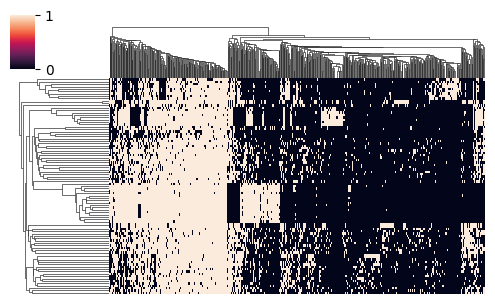

In [6]:
sns.clustermap(mat, xticklabels=[], yticklabels=[], figsize=(5, 3))

got 2 labels


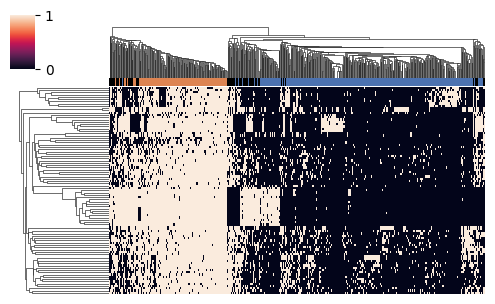

In [7]:
min_cluster_size=135
labels = sklearn.cluster.HDBSCAN(min_cluster_size=min_cluster_size).fit_predict(1 - mat.T)

print(f'got {numpy.unique(labels).max() + 1} labels')
palette = sns.color_palette('deep', numpy.unique(labels).max() + 1)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]

sns.clustermap(mat, xticklabels=[], yticklabels=[], figsize=(5, 3), col_colors=colors)

## Try with association matrix instead, w/distance precomputed...

In [8]:
cmp = numpy.load('agatha-genomes.10k.all.assoc')
cmplabelsfile = 'agatha-genomes.10k.all.assoc.labels.csv'
categories_file = 'agatha-genomes.10k.all.assoc.categories.csv'

print(f'loaded {len(cmp)} elements')

loaded 608 elements


In [9]:
from sourmash_plugin_betterplot import load_categories_csv
with sourmash_args.FileInputCSV(cmplabelsfile) as r:
    labelinfo = list(r)
category_map, category_colors = load_categories_csv(categories_file, labelinfo)

found category key: label


got 5 labels


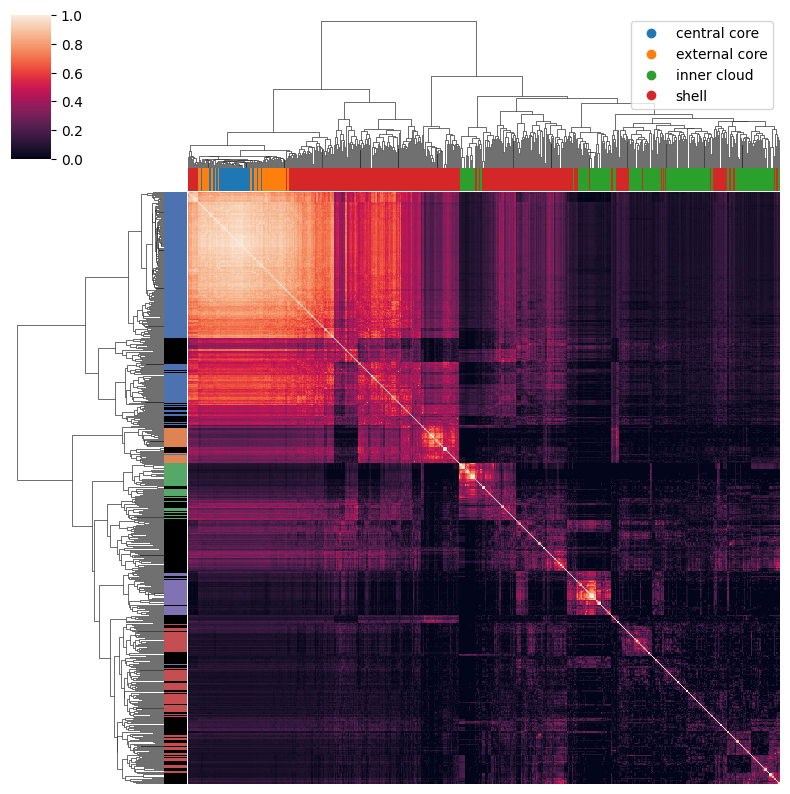

In [10]:
min_cluster_size=15
labels = sklearn.cluster.HDBSCAN(min_cluster_size=min_cluster_size).fit_predict(1 - cmp)

print(f'got {numpy.unique(labels).max() + 1} labels')
palette = sns.color_palette('deep', numpy.unique(labels).max() + 1)
cluster_colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]

fig = sns.clustermap(cmp, xticklabels=[], yticklabels=[], figsize=(8, 8), row_colors=cluster_colors, col_colors=category_colors)

# create a custom legend of just the pangenome rank colors on the columns                     
legend_elements = []
for k, v in category_map.items():
    legend_elements.append(
        Line2D([0], [0], color=v, label=k, marker="o", lw=0)
    )
fig.ax_col_dendrogram.legend(handles=legend_elements)

### (MDS viz is not particularly helpful, it seems)

In [11]:
mds = sklearn.manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=42)
mds_coords = mds.fit_transform(1 - cmp)


Text(0, 0.5, 'Dimension 2')

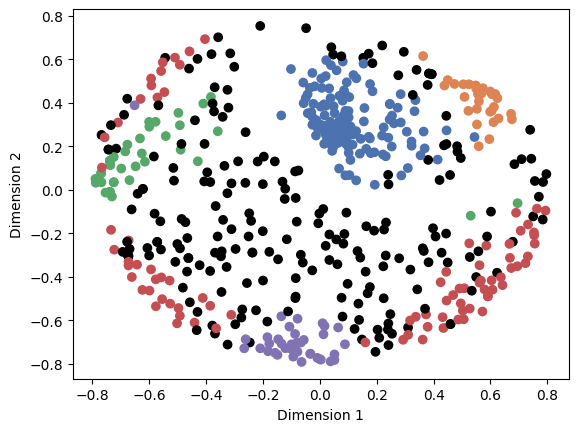

In [12]:
plt.scatter(mds_coords[:, 0], mds_coords[:, 1], color=cluster_colors)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

## What about t-SNE?

In [13]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=42, perplexity=50) # play with: perplexity
tsne_coords = tsne.fit_transform(1 - cmp)


Text(0, 0.5, 'Dimension 2')

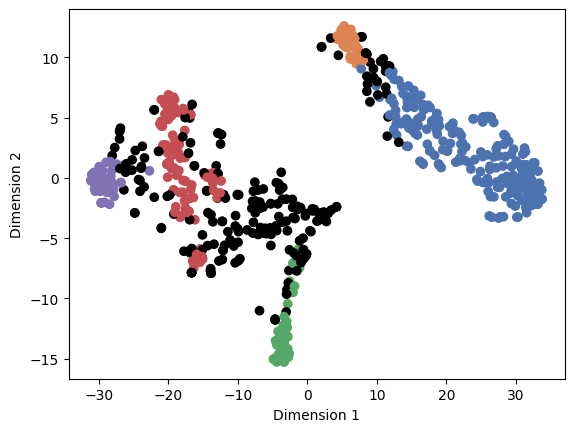

In [14]:
plt.scatter(tsne_coords[:, 0], tsne_coords[:, 1], color=cluster_colors)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

In [15]:
## ok, whatever, pull out the clusters ;)

hashinfo = list(labelinfo)

hashinfo.sort(key=lambda row: int(row["sort_order"]))
hashvals = [ int(row['label']) for row in hashinfo ]

clusters_d = defaultdict(set)

for hashval, cluster_num in zip(hashvals, labels):
    if cluster_num >= 0:
        clusters_d[cluster_num].add(hashval)

In [16]:
print(len(clusters_d))

5


In [17]:
for k, v in sorted(clusters_d.items(), key=lambda v: -len(v[1])):
    print(f"cluster {k} has size {len(v)}")

print(sum([ len(v) for v in clusters_d.values() ]))

cluster 0 has size 197
cluster 3 has size 86
cluster 4 has size 41
cluster 2 has size 39
cluster 1 has size 29
392


In [18]:
print(f'got {numpy.unique(labels).max()} labels')
#palette = sns.color_palette('deep', numpy.unique(labels).max() + 1)
#colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]

#sns.clustermap(mat, xticklabels=[], yticklabels=[], figsize=(5, 3), col_colors=colors)

got 4 labels


In [19]:
len(labels), len(hashvals)

(608, 608)

In [20]:
hashval_to_cluster_id = {}
for cluster_id, vv in clusters_d.items():
    for hashval in vv:
        hashval_to_cluster_id[hashval] = cluster_id    

print(len(hashval_to_cluster_id))

labels2 = [ hashval_to_cluster_id.get(int(h), -1) for h, _ in against_d_items ]
print('items:', against_d_items[:5])
print('len items:', len(against_d_items))
print('labels2 unclust:', labels2.count(-1))

palette2 = sns.color_palette('deep', numpy.unique(labels2).max() + 1)
colors2 = [palette2[x] if x >= 0 else (1.0, 1.0, 1.0) for x in labels2]

print('len labels:', len(labels), len(labels2))
print('labels unclust:', list(labels).count(-1), len(labels) - list(labels).count(-1))


392
items: [('1010134035032244', 0), ('1014626931059816', 1), ('1014822328648043', 2), ('1018420966254520', 3), ('1018639934610458', 4)]
len items: 608
labels2 unclust: 216
len labels: 608 608
labels unclust: 216 392


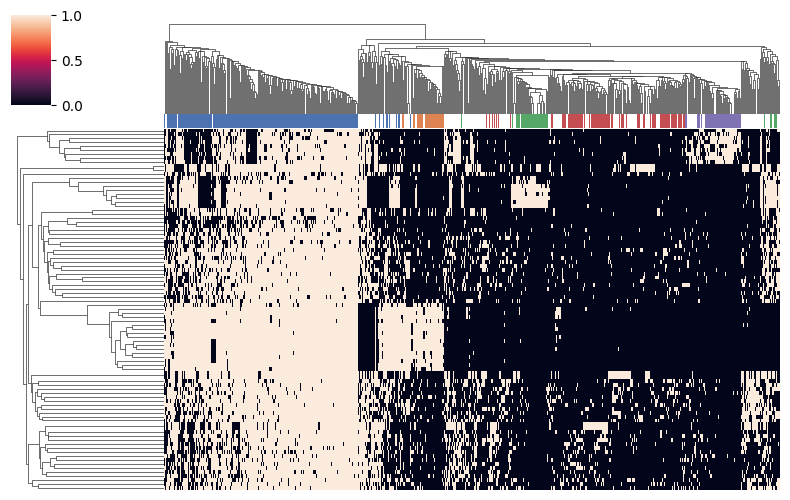

In [21]:
sns.clustermap(mat, xticklabels=[], yticklabels=[], figsize=(8, 5), col_colors=colors2)

loaded 21120 rows from 'agatha-genomes.10k.presence.csv'
loaded 91 x 608 total elements
making matrix: 91 x 392 total elements


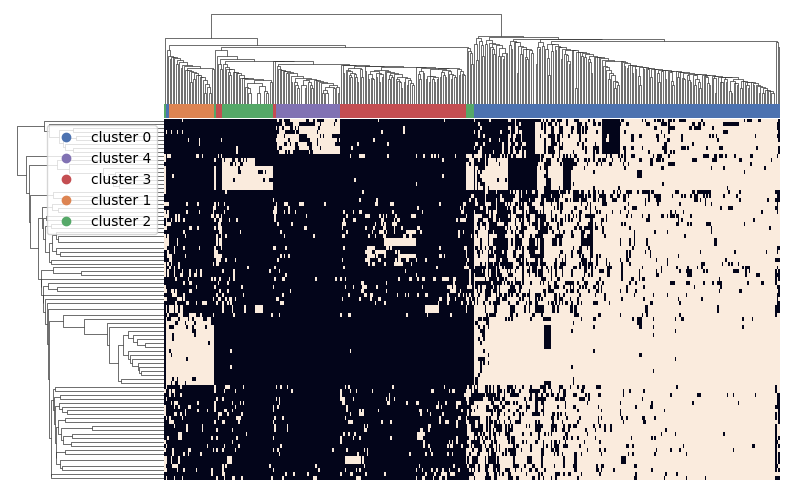

In [22]:
# hmm, try filtering, wat wat.

csvfile = 'agatha-genomes.10k.presence.csv'

with sourmash_args.FileInputCSV(csvfile) as r:
    rows2 = list(r)

# pick out all the distinct queries/matches.                            
print(f"loaded {len(rows2)} rows from '{csvfile}'")
queries2 = set([row["query_name"] for row in rows2])
against2 = set([row["match_name"] for row in rows2])
print(f"loaded {len(queries2)} x {len(against2)} total elements")

queries2 = list(sorted(queries2))
against2 = list(sorted(against2))

query2_d = {}
for n, query_name in enumerate(queries2):
    query2_d[query_name] = n

against2_d = {}
n = 0
for against_name in against2:
    hashval = int(against_name)
    if hashval in hashval_to_cluster_id:
        against2_d[against_name] = n
        n += 1

query2_d_items = list(sorted(query2_d.items(), key=lambda x: x[1]))
against2_d_items = list(sorted(against2_d.items(), key=lambda x: x[1]))

print(f"making matrix: {len(query2_d)} x {len(against2_d)} total elements")
mat2 = numpy.zeros((len(query2_d), len(against2_d)))

colors2 = [ (1.0, 1.0, 1.0) for _ in range(len(against2_d)) ]
palette2 = sns.color_palette('deep', len(clusters_d))

for row in rows2:
    q = row["query_name"]
    qi = query2_d[q]
    m = row["match_name"]
    mi = against2_d.get(m)
    if mi is not None:
        value = float(row['presence'])
        assert (value == 1.0 or value == 0.0)

        mat2[qi, mi] = value
        cluster_id = hashval_to_cluster_id[int(m)]
        colors2[mi] = palette2[cluster_id]

fig = sns.clustermap(mat2, xticklabels=[], yticklabels=[], figsize=(8, 5), col_colors=colors2, cbar_pos=None)

from matplotlib.lines import Line2D

legend_elements = []
for k in clusters_d:
    color = palette2[k]
    legend_elements.append(
        Line2D([0], [0], color=color, label=f"cluster {k}", marker="o", lw=0)
    )
    fig.ax_row_dendrogram.legend(handles=legend_elements)

loaded 21120 rows from 'agatha-genomes.10k.presence.csv'
loaded 91 x 608 total elements
making matrix: 91 x 608 total elements


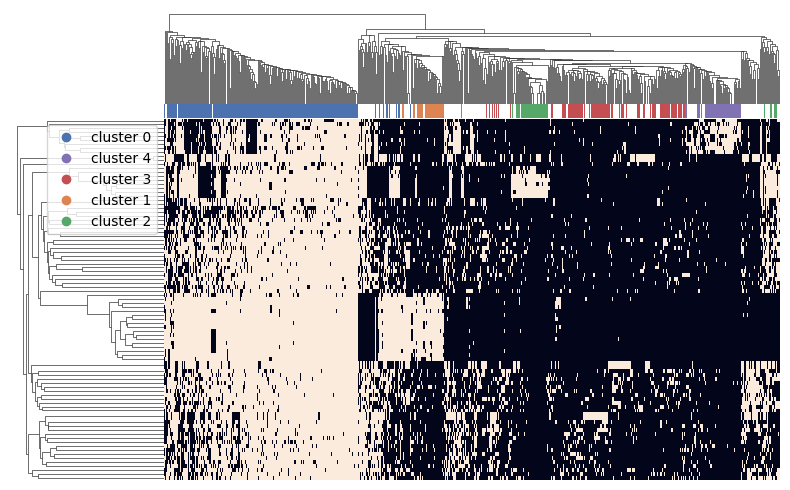

In [23]:
# hmm, try filtering, wat wat.

csvfile = 'agatha-genomes.10k.presence.csv'

with sourmash_args.FileInputCSV(csvfile) as r:
    rows2 = list(r)

# pick out all the distinct queries/matches.                            
print(f"loaded {len(rows2)} rows from '{csvfile}'")
queries2 = set([row["query_name"] for row in rows2])
against2 = set([row["match_name"] for row in rows2])
print(f"loaded {len(queries2)} x {len(against2)} total elements")

## filter by assoc list
filter_set = set([ int(x) for n, x in enumerate(against2) if n % 2 == 0 ])
hashinfo = list(labelinfo)
filter_set = set([ int(row['label']) for row in hashinfo ])

queries2 = list(sorted(queries2))
against2 = list(sorted(against2))

query2_d = {}
for n, query_name in enumerate(queries2):
    query2_d[query_name] = n

against2_d = {}
n = 0
for against_name in against2:
    if int(against_name) in filter_set:
        against2_d[against_name] = n
        n += 1

query2_d_items = list(sorted(query2_d.items(), key=lambda x: x[1]))
against2_d_items = list(sorted(against2_d.items(), key=lambda x: x[1]))

print(f"making matrix: {len(query2_d)} x {len(against2_d)} total elements")
mat2 = numpy.zeros((len(query2_d), len(against2_d)))

colors2 = [ (1.0, 1.0, 1.0) for _ in range(len(against2_d)) ]
palette2 = sns.color_palette('deep', len(clusters_d))

for row in rows2:
    q = row["query_name"]
    qi = query2_d[q]
    m = row["match_name"]
    hashval = int(m)
    if hashval not in filter_set:
        continue
    mi = against2_d.get(m)
    value = float(row['presence'])
    assert (value == 1.0 or value == 0.0)

    mat2[qi, mi] = value

    if hashval in hashval_to_cluster_id:
        cluster_id = hashval_to_cluster_id[hashval]
        colors2[mi] = palette2[cluster_id]
    else:
        colors2[mi] = (1.0, 1.0, 1.0)

fig = sns.clustermap(mat2, xticklabels=[], yticklabels=[], figsize=(8, 5), col_colors=colors2, cbar_pos=None)

from matplotlib.lines import Line2D

legend_elements = []
for k in clusters_d:
    color = palette2[k]
    legend_elements.append(
        Line2D([0], [0], color=color, label=f"cluster {k}", marker="o", lw=0)
    )
    fig.ax_row_dendrogram.legend(handles=legend_elements)